In [1]:
import torch
import torch.cuda as cuda
import torch.nn as nn

from torch.autograd import Variable

from torchvision import datasets
from torchvision import transforms

# The functional module contains helper functions for defining neural network layers as simple functions
import torch.nn.functional as F

import matplotlib.pyplot as plt

import numpy as np

import torchvision.models as models

from torch.optim import lr_scheduler

import torch.optim as optim

import os

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224), 0),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224), 0),
        transforms.ToTensor(),
    ]),
}

data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
import torchvision

torch.Size([3, 228, 906])


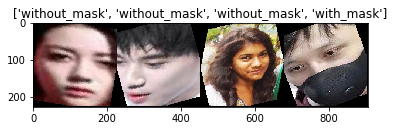

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    print(inp.shape)
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
import copy, time

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
PATH = 'trained_mobilenet.pth'

In [9]:
model1 = models.mobilenet_v2(pretrained=True, progress=True)
num_ftrs = model1.classifier[1].in_features
model1.classifier[1] = nn.Sequential(
                        nn.Linear(num_ftrs, 2),
                        nn.Softmax(-1)
                    )


model1.load_state_dict(torch.load(PATH, map_location=device))
model1.eval()

model1.to(device)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [10]:
# model_vgg = models.vgg19(pretrained=True, progress=True)
# num_ftrs = model_vgg.classifier[6].in_features
# model_vgg.classifier[6] = nn.Sequential(
#                         nn.Linear(num_ftrs, 400),
#                         nn.Linear(400, 2),
#                         nn.Softmax(-1)
#                     )

# model1 = model_vgg.to(device)


In [11]:
# class CNN_Model(nn.Module):
    
#     def __init__(self):
#         super().__init__()
        
#         #Input size of the image is 224 x 224 x 3
               
#         # NOTE: All Conv2d layers have a default padding of 0 and stride of 1,
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=3)      # 222 x 222 x 64  (after 1st convolution)
#         self.relu1 = nn.ReLU()                            # Same as above
        
#         # Convolution Layer 2
#         self.conv2 = nn.Conv2d(64, 128, kernel_size=3)     # 220 x 220 x 128  (after 2nd convolution)
#         #self.conv2_drop = nn.Dropout2d(p=0.5)            # Dropout is a regularization technqiue we discussed in class
#         self.maxpool2 = nn.MaxPool2d(2)                   # 110 x 110 x 128  (after pooling)
#         self.relu2 = nn.ReLU()                            # Same as above 
        
#         # Convolution Layer 3
#         self.conv3 = nn.Conv2d(128, 256, kernel_size=3)     # 108 x 108 x 256  (after 3nd convolution)
#         #self.conv2_drop = nn.Dropout2d(p=0.5)            # Dropout is a regularization technqiue we discussed in class
#         self.maxpool3 = nn.MaxPool2d(2)                   # 54 x 54 x 256  (after pooling)
#         self.relu3 = nn.ReLU()                            # Same as above 
        
#         # Convolution Layer 4
#         self.conv4 = nn.Conv2d(256, 512, kernel_size=3)     # 52 x 52 x 512  (after 3nd convolution)
#         #self.conv2_drop = nn.Dropout2d(p=0.5)            # Dropout is a regularization technqiue we discussed in class
#         self.maxpool4 = nn.MaxPool2d(2)                   # 26 x 26 x 512  (after pooling)
#         self.relu4 = nn.ReLU()                            # Same as above 
        
#         # Convolution Layer 5
#         self.conv5 = nn.Conv2d(512, 1024, kernel_size=3)     # 24 x 24 x 1024  (after 3nd convolution)
#         #self.conv2_drop = nn.Dropout2d(p=0.5)            # Dropout is a regularization technqiue we discussed in class
#         self.maxpool5 = nn.MaxPool2d(2)                   # 12 x 12 x 1024  (after pooling)
#         self.relu5 = nn.ReLU()                            # Same as above 
        
#         # Fully connected layers
#         self.fc1 = nn.Linear(12*12*1024, 50)
#         self.fc2 = nn.Linear(50, 2)
 
#     def forward(self, x):
        
#         # Convolution Layer 1                    
#         x = self.conv1(x)                        
#         x = self.relu1(x)                        
        
#         # Convolution Layer 2
#         x = self.conv2(x)               
#         #x = self.conv2_drop(x)
#         x = self.maxpool2(x)
#         x = self.relu2(x)
        
#         # Convolution Layer 3
#         x = self.conv3(x)               
#         #x = self.conv2_drop(x)
#         x = self.maxpool3(x)
#         x = self.relu3(x)
        
#         # Convolution Layer 4
#         x = self.conv4(x)               
#         #x = self.conv2_drop(x)
#         x = self.maxpool4(x)
#         x = self.relu4(x)
        
#         # Convolution Layer 5
#         x = self.conv5(x)               
#         #x = self.conv2_drop(x)
#         x = self.maxpool5(x)
#         x = self.relu5(x)
        
#         # Switch from activation maps to vectors
#         x = x.view(-1, 12*12*1024)
        
#         # Fully connected layer 1
#         x = self.fc1(x)
#         x = F.relu(x)
#         #x = F.dropout(x, training=True)
        
#         # Fully connected layer 2
#         x = self.fc2(x)
        
#         return x

In [12]:
# model1 = CNN_Model().to(device)

torch.Size([3, 224, 224])


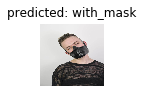

torch.Size([3, 224, 224])


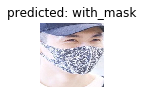

torch.Size([3, 224, 224])


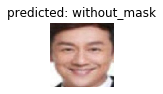

torch.Size([3, 224, 224])


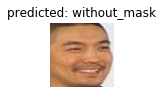

torch.Size([3, 224, 224])


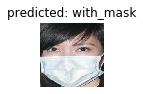

torch.Size([3, 224, 224])


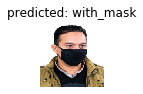

In [13]:
visualize_model(model1)

plt.ioff()
plt.show()

In [14]:
import imutils
from imutils.video import VideoStream

In [15]:
import PIL

def preprocess(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = PIL.Image.fromarray(image)     
    image = data_transforms['val'](image)
    image = image.cuda()
    image = image.unsqueeze(0) 
    return image    

In [16]:
# import cv2

# def detect_and_predict_mask(frame, faceNet, maskNet):
# # grab the dimensions of the frame and then construct a blob
# # from it
#     (h, w) = frame.shape[:2]
#     blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),
#         (104.0, 177.0, 123.0))

#     # pass the blob through the network and obtain the face detections
#     faceNet.setInput(blob)
#     detections = faceNet.forward()
# #     print(detections.shape)

#     # initialize our list of faces, their corresponding locations,
#     # and the list of predictions from our face mask network
#     faces = []
#     locs = []
#     prediction = []

#     # loop over the detections
#     for i in range(0, detections.shape[2]):
#         # extract the confidence (i.e., probability) associated with
#         # the detection
#         confidence = detections[0, 0, i, 2]

#         # filter out weak detections by ensuring the confidence is
#         # greater than the minimum confidence
#         if confidence > 0.5:
#         # compute the (x, y)-coordinates of the bounding box for
#         # the object
#             box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
#             (startX, startY, endX, endY) = box.astype("int")

#             # ensure the bounding boxes fall within the dimensions of
#             # the frame
#             (startX, startY) = (max(0, startX), max(0, startY))
#             (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

#             # extract the face ROI, convert it from BGR to RGB channel
#             # ordering, resize it to 224x224, and preprocess it
#             face = frame[startY:endY, startX:endX]
# #             face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
# #face = cv2.resize(face, (224, 224))
# #face = img_to_array(face)
#             face = preprocess(face)

# # add the face and bounding boxes to their respective
# # lists
#             faces.append(face)
#             locs.append((startX, startY, endX, endY))

#     # only make a predictions if at least one face was detected
#     if len(faces) > 0:
#         # for faster inference we'll make batch predictions on *all*
#         # faces at the same time rather than one-by-one predictions in the above `for` loop
# #         print(type(faces))
# #         print(len(faces))
# #         print(faces[0].shape)
# #         faces = np.array(faces, dtype="float32")
# #  preds = maskNet.predict(faces, batch_size=32)
        
#         prediction   = maskNet(face.to(device))
# #         show_score, preds = torch.max(prediction, 1)

# #         show_res = class_names[preds]

#     # return a 2-tuple of the face locations and their corresponding
#     # locations
#     return (locs, prediction)

# # load our serialized face detector model from disk
# prototxtPath = r"face_detector\deploy.prototxt"
# weightsPath = r"face_detector\res10_300x300_ssd_iter_140000.caffemodel"
# faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# # load the face mask detector model from disk
# maskNet = model1

# # initialize the video stream
# print("[INFO] starting video stream...")
# vs = VideoStream(src=0).start()

# # loop over the frames from the video stream
# while True:
#     # grab the frame from the threaded video stream and resize it
#     # to have a maximum width of 400 pixels
#     frame = vs.read()
#     frame = imutils.resize(frame, width=400)

#     # detect faces in the frame and determine if they are wearing a
#     # face mask or not
#     (locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

#     # loop over the detected face locations and their corresponding
#     # locations
#     for (box, pred) in zip(locs, preds):
#         # unpack the bounding box and predictions
#         (startX, startY, endX, endY) = box
#         (mask, withoutMask) = pred

#         # determine the class label and color we'll use to draw
#         # the bounding box and text
#         label = "Mask" if mask > withoutMask else "No Mask"
#         color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

#         # include the probability in the label
#         label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

#         # display the label and bounding box rectangle on the output
#         # frame
#         cv2.putText(frame, label, (startX, startY - 10),
#         cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
#         cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

#     # show the output frame
#     cv2.imshow("Frame", frame)
#     key = cv2.waitKey(1) & 0xFF

#     # if the `q` key was pressed, break from the loop
#     if key == ord("q"):
#         break

# # do a bit of cleanup
# cv2.destroyAllWindows()
# vs.stop()

In [17]:
# vs.stream.release()

In [18]:
# import cv2
# import imutils
# from imutils.video import VideoStream
# import numpy as np
# import os
# import time



# path_without_mask = 'Manual Dataset/without_mask/'

# path_with_mask = 'Manual Dataset/with_mask/'

# a = os.listdir(path_with_mask)
# b = [int(i.split('.')[0]) for i in a]
# b.sort()

# no_frames = b[-1]


# def detect_and_save_mask(frame, faceNet, no_frames):

#     (h, w) = frame.shape[:2]
#     blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),
#         (104.0, 177.0, 123.0))

#     faceNet.setInput(blob)
#     detections = faceNet.forward()

#     locs = []
#     for i in range(0, detections.shape[2]):

#         confidence = detections[0, 0, i, 2]

#         if confidence > 0.5:
#             box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
#             (startX, startY, endX, endY) = box.astype("int")

#             (startX, startY) = (max(0, startX), max(0, startY))
#             (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

#             face = frame[startY:endY, startX:endX]
#             cv2.imwrite(path_with_mask+str(no_frames)+'.jpg', face)
#             print('saved')
#             locs.append((startX, startY, endX, endY))

#     return locs

# prototxtPath = r"face_detector\deploy.prototxt"
# weightsPath = r"face_detector\res10_300x300_ssd_iter_140000.caffemodel"
# faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# print("[INFO] starting video stream...")
# vs = VideoStream(src=0).start()
# time.sleep(10)

# while True:
#     no_frames += 1
#     if no_frames == b[-1]+20:
#         break
#     frame = vs.read()
#     frame = imutils.resize(frame, width=400)

#     locs = detect_and_save_mask(frame, faceNet, no_frames)

#     for box in locs:
#         (startX, startY, endX, endY) = box
        
#         color = (0, 255, 0)

#         cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

#     cv2.imshow("Frame", frame)
#     key = cv2.waitKey(1) & 0xFF

#     if key == ord("q"):
#         break

# cv2.destroyAllWindows()
# vs.stop()

In [19]:
# vs.stop()

In [20]:
# vs.stream.release()

In [21]:
import time

In [34]:
import cv2

def detect_and_predict_mask(frame, faceNet, maskNet):
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),
        (104.0, 177.0, 123.0))

    faceNet.setInput(blob)
    detections = faceNet.forward()

    faces = []
    locs = []
    prediction = []

    for i in range(0, detections.shape[2]):

        confidence = detections[0, 0, i, 2]

        if confidence > 0.5:

            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")


            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))


            face = frame[startY:endY, startX:endX]

            face = preprocess(face)

            faces.append(face)
            locs.append((startX, startY, endX, endY))

    if len(faces) > 0:        
        prediction   = maskNet(face.to(device))

    return (locs, prediction)

prototxtPath = r"face_detector\deploy.prototxt"
weightsPath = r"face_detector\res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
maskNet = model1

# initialize the video stream
print("[INFO] starting video stream...")
vs = cv2.VideoCapture(0)

frame_width = int(vs.get(3))
frame_height = int(vs.get(4))
out = cv2.VideoWriter('sample-mobilenet.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 30, (frame_width, frame_height))

st = time.time()
# loop over the frames from the video stream
while vs.isOpened():
    ret, frame = vs.read()
    
    if ret == False:
        break

    
    (locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)
    for (box, pred) in zip(locs, preds):
        (startX, startY, endX, endY) = box
        (mask, withoutMask) = pred

        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

        cv2.putText(frame, label, (startX, startY - 10),
        cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

    out.write(frame)

    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF

    if key == ord("q"):
        break

vs.release()
out.release()
cv2.destroyAllWindows()
end_time = time.time()


[INFO] starting video stream...


In [32]:
print(end_time - st)

0.036112070083618164


In [33]:
vs.release()

cv2.destroyAllWindows()

In [25]:
import cv2

In [26]:
import torch

In [27]:
import cv2

def detect_and_predict_mask(frame, faceNet, maskNet):
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),
        (104.0, 177.0, 123.0))

    faceNet.setInput(blob)
    detections = faceNet.forward()

    faces = []
    locs = []
    prediction = []
    
    print(detections.shape)

    for i in range(0, detections.shape[2]):
#         print(i)

        confidence = detections[0, 0, i, 2]

        if confidence > 0.5:

            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")


            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))


            face = frame[startY:endY, startX:endX]

            face = preprocess(face)
#             print(im)

            faces.append(face)
            locs.append((startX, startY, endX, endY))

    if len(faces) > 0: 
#         t = torch.cat(faces)
#         print("t shape is ",t.shape)
        prediction   = maskNet(torch.cat(faces).to(device))

    return (locs, prediction)

prototxtPath = r"face_detector\deploy.prototxt"
weightsPath = r"face_detector\res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
maskNet = model1

# initialize the video stream
# print("[INFO] starting video stream...")
# vs = cv2.VideoCapture("video/sample.mp4")

# frame_width = int(vs.get(3))
# frame_height = int(vs.get(4))
# out = cv2.VideoWriter('sample-mobilenet.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 30, (frame_width, frame_height))

st = time.time()
# loop over the frames from the video stream

# ret, frame = vs.read()

image = cv2.imread("test5.jpg")

image = cv2.resize(image, (400, 300))

# if ret == False:
#     break


(locs, preds) = detect_and_predict_mask(image, faceNet, maskNet)
for (box, pred) in zip(locs, preds):
    (startX, startY, endX, endY) = box
    (mask, withoutMask) = pred

    label = "Mask" if mask > withoutMask else "No Mask"
    color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

    label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

    cv2.putText(image, label, (startX, startY - 10),
    cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
    cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

cv2.imshow("image", image)

cv2.waitKey(0)  

# vs.release()
# out.release()
cv2.destroyAllWindows()
end_time = time.time()


(1, 1, 200, 7)


In [28]:
import PIL

def preprocess(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = PIL.Image.fromarray(image)     
#     im = image.copy()
    image = data_transforms['val'](image)
    image = image.cuda()
    image = image.unsqueeze(0) 
    return image  